# Scripts for Final Exam

## Index

**Numerical Integration:** [(here)](#Numerical-Integration)  
* Midpoint Rule
* Trapezoidal Rule
* Simpson's Rule  
* Approximate vale of an integral given tolerance

**Bonds:**  [(here)](#Bonds)
* Bond price given zero rate curve
* Bond price given instantaneous interest rate curve **[TODO]**
* Price, Duration and Convexity of bond given yield
* Bond yield
* Boostrapping

**Options:** [(here)](#Options)
* Normal CDF
* Black Scholes European
* Implied Volatility
* Implied Strike

**Numerical Nonlinear Equations:** [(here)](#Numerical-Nonlinear-Equations) 
* Bisection Method **[FIX, DOESN'T WORK]**
* Secant Method
* Newton's Method

**Previous Exams** [(here)](#Previous
-Exams) 
* Fall 2016 

**Examples:** [(here)](#Examples) 
* Numerical Integration
* Bonds
* Options
* Numerical Nonlinear Equations

**Miscelanea:**
* Solve linear systems of equations
* Greeks

**TODOs:**
* N-dim Newton's Method?
* N-dim Approximate Newton's Method?

## Imports

In [3]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from functools import partial
from math import log, exp, sqrt 
%matplotlib inline

## Numerical Integration

In [4]:
def midpoint_rule(a,b,n, f_int_x):
    '''
    Inputs:
        a: left endpoint of the integration interval
        b: right endpoint of the integration interval
        n: number of partition intervals
        f_int_x: function evaluating f(x)
        
    Output:
        I_midpoint: Midpoint Rule approximation of 
                    integral of f(x) from b to a
    '''
    h = (b-a)/n
    I_midpoint = 0
    for i in range(1,n+1):
        I_midpoint = I_midpoint + f_int_x(a + (i - 1/2) * h)
    I_midpoint = h * I_midpoint
    return I_midpoint

def trapezoidal_rule(a,b,n, f_int_x):
    '''
    Inputs:
        a: left endpoint of the integration interval
        b: right endpoint of the integration interval
        n: number of partition intervals
        f_int_x: function evaluating f(x)
        
    Output:
        I_midpoint: Midpoint Rule approximation of 
                    integral of f(x) from b to a
    '''
    h = (b-a)/n
    I_trap = f_int_x(a)/2 + f_int_x(b)/2
    for i in range(1,n):
        I_trap = I_trap + f_int_x(a + i * h)
    I_trap = h * I_trap
    return I_trap

def simpson_rule(a,b,n, f_int_x):
    '''
    Inputs:
        a: left endpoint of the integration interval
        b: right endpoint of the integration interval
        n: number of partition intervals
        f_int_x: function evaluating f(x)
        
    Output:
        I_simpson: Simpson's Rule approximation of 
                    integral of f(x) from b to a
    '''
    h = (b-a)/n
    I_simpson = f_int_x(a)/6 + f_int_x(b)/6 
    for i in range(1,n):
        I_simpson = I_simpson + f_int_x(a + (i*h))/3
    for i in range(1,n+1):
        I_simpson = I_simpson + 2 * f_int_x(a + (i - 1/2) * h) / 3
    
    I_simpson = h * I_simpson
    return I_simpson

def integral_approx(tol, I_numerical_n):
    ''' 
    Inputs:
        tol: prescribed tolerance
        I_numerical_n: result of the numerical integration rule
        with n intervals; any integration rule can be used
        
    Outputs:
        I_approx: approximation of integral of f(x) from a to b with tolerance tol
    '''
    n = 4
    I_old = I_numerical_n(n=n)
    n = 2*n
    I_new = I_numerical_n(n=n)
    int_results = []
    while np.abs(I_new - I_old) > tol:
        I_old  = I_new
        n = 2*n
        I_new = I_numerical_n(n=n)
        int_results.append( (n,I_new) )
    I_approx = I_new
    return I_approx, int_results

[Back to Index](#Index)

## Bonds

In [439]:
def get_value_cash_flows(n, C, FV = 100):
    ''' 
       Computes the value of the cash flows given constant coupon rate "C" in "n" periods 
       for a bond with face value "FV" 
    '''
    
    cash_flows = [C * FV,] *n
    cash_flows[-1] += FV  # add principal at final cash flow 
    return cash_flows

# Bond price given zero rate curve
def risk_zero_curve(t):
    return 0.015 + t/(100+np.sqrt(1+t**2))

def bond_price(t_cash_flow,v_cash_flow):
    ''' 
        Compute bond price from cash flows, coupon schedule and risk-free zero rate curve
    '''
    r_0_t = np.array([risk_zero_curve(x) for x in t_cash_flow])
    t_cash_flow = np.array(t_cash_flow)  
    disc = np.exp(-r_0_t * t_cash_flow)
    return (disc * np.array(v_cash_flow)).sum()

# Bond price given instantaneous interest rate curve
# [TODO]

# Price, Duration and Convexity of bond given yield
def price_duration_convexity(n,t_cash_flow,v_cash_flow, y):
    '''
    Implementation of pseudocode from table 2.7 of the book 
    "A Primer for the Mathematics of Financial Engineering"
        Inputs:
            T: bond maturity
            n: number of cash flows
            t_cash_flow: vector of cash flows (of size n)
            v_cash_flow: vector of cash flows (of size n)
            y: yield of the bond
            
        Outputs:
            B: price of the bond
            D: duration of the bond
            C: convexity of the bond
    '''
    B,D,C = 0,0,0
    for i in range(n):
        disc_i = np.exp(-t_cash_flow[i] * y)
        B = B + v_cash_flow[i] * disc_i
        D = D + t_cash_flow[i] * v_cash_flow[i] *  disc_i
        C = C + t_cash_flow[i]**2 * v_cash_flow[i] *  disc_i
    
    D = D / B
    C = C / B
    return B,D,C


# Bond yield
def bond_yield_Newton(B, n, t_cash_flow, v_cash_flow , tol = 10**(-6)):
    '''
    Implementation of pseudocode from table 5.6 of the book 
    "A Primer for the Mathematics of Financial Engineering"
    
    Inputs:
        B : price of the bond
        n : number of cash flows
        t_cash_flow : cash flow dates (vector of size n)
        v_cash_flow : cash flows (vector of size n)
        tol : tolerance for declaring convergence of Newton's method
    
    Output:
        x_new : the yield of the bond
    '''
    x0 = 0.1 # initial guess: 10% yield
    x_new = x0
    x_old = x0 - 1
    
    # Use numpy arrays for vectorization
    _v_cash_flow = np.array(v_cash_flow)
    _t_cash_flow = np.array(t_cash_flow)
    
    while np.abs(x_new - x_old) > tol:
        x_old = x_new
        print (round(x_new,6))
        
        numer = (_v_cash_flow * np.exp(-x_old * _t_cash_flow )).sum() - B
        denom = (_t_cash_flow * _v_cash_flow * 
                     np.exp(-x_old * _t_cash_flow)).sum()
        
        x_new = x_old + numer / denom
    return x_new

# Boostrapping
# [TODO]

In [4]:
# Boostrapping

# Inputs: Maturity, Coupon Rate and Price for a set of bonds with different maturities
# Steps: 
# 1) Solve for the interest rate for known rates
# 2) If there is a gap in maturities, make x as unknown and explain the rest as linear combinations of the unkonwn

# book data
bdt =     pd.DataFrame( {'Maturity_in_months' : [6, 12, 36, 60],
                        'Coupon_Rate' : [0, 4, 4, 4],
                        'Price' : [99, 102, 103.5, 109]},
                     columns = ['Maturity_in_months', 'Coupon_Rate', 'Price'])
bdt

,Maturity_in_months,Coupon_Rate,Price
0,6,0,99.0
1,12,4,102.0
2,36,4,103.5
3,60,4,109.0


In [5]:
# Bootstraping from book
def get_implied_rate_r02( B,c,r_05,r_1,x0, tol = 10**(-6) ) :
    '''
    XXX
    Semianual
    '''
    
    r_15 = lambda x:  (r_1 + x)/2
    r_2  = lambda x: x
    
    x_new = x0
    x_old = x0-1
    it = 0
    while np.abs(x_new - x_old) > tol:
        x_old = x_new
        print ('Iter/Imp rate r02: {}/{}'.format(it,x_new))
        it += 1
        f =   ( c/2 * np.exp(-0.5 * r_05) + 
                c/2 * np.exp(-1 * r_1)    +
                c/2 * np.exp(-1.5 * r_15(x_new)) +
                (100 + c/2) * np.exp(-2 * r_2(x_new))-B)
             
        f_p = ( -1.5 * c/2 * np.exp(-1.5 * r_15(x_new)) +
                -2 * (100 + c/2) * np.exp(-2 * r_2(x_new)) )
        
        x_new = (x_new - f/f_p)
    return x_new


def get_implied_rate_r05( B,c,r_05,r_1,r_15,r_2,x0, tol = 10**(-6) ) :
    '''
    XXX
    Semianual
    '''
    # rates as a function by linear interpolation
    r_25 = lambda x: (x + 5*r_2)/6
    r_3  = lambda x: (x + 2*r_2)/3
    r_35 = lambda x: (x + r_2)/2
    r_4  = lambda x: (2*x + r_2)/3
    r_45  = lambda x: (5*x + r_2)/6
    r_5  = lambda x: x
    
    x_new = x0
    x_old = x0-1
    it = 0
    while np.abs(x_new - x_old) > tol:
        x_old = x_new
        print ('Iter/Imp rate r05: {}/{}'.format(it,x_new))
        it += 1
        f =   ( c/2 * np.exp(-0.5 * r_05) + 
                c/2 * np.exp(-1 * r_1)    +
                c/2 * np.exp(-1.5 * r_15) +
                c/2 * np.exp(-2 * r_2) +
                c/2 * np.exp(-2.5 * r_25(x_new)) +
                c/2 * np.exp(-3 * r_3(x_new)) +
                c/2 * np.exp(-3.5 * r_35(x_new)) +
                c/2 * np.exp(-4 * r_4(x_new)) +
                c/2 * np.exp(-4.5 * r_45(x_new)) +
                (100 + c/2) * np.exp(-5 * r_5(x_new))-B)
             
        f_p = ( -2.5 * c/2 * np.exp(-2.5 * r_25(x_new)) +
                -3 * c/2 * np.exp(-3 * r_3(x_new)) +
                -3.5 * c/2 * np.exp(-3.5 * r_35(x_new)) +
                -4 * c/2 * np.exp(-4 * r_4(x_new)) +
                -4.5 * c/2 * np.exp(-4.5 * r_45(x_new)) + 
                -5 * (100 + c/2) * np.exp(-5 * r_5(x_new)) )
               
        x_new = (x_new - f/f_p)
    return x_new

# Replicating book
# Find "known" rates
# T = 6 months
br_05 = (np.log(100 + 0/2)- np.log(99) )  / 0.5
bdc_05 =   bdt.Coupon_Rate[1]/2 * np.exp(- 0.5 * br_05) #discounted coupon

# T = 1 year
br_1 =  (np.log(100 + bdt.Coupon_Rate[1]/2) - np.log(bdt.Price[1] - bdc_05))
bdc_1 = bdt.Coupon_Rate[1]/2 * np.exp(- 1 * br_1)

# T = 2 year
br_2 = get_implied_rate_r02(bdt.Price[2], bdt.Coupon_Rate[2], br_05, br_1, 0.05 )
bdc_2 = bdt.Coupon_Rate[2]/2 * np.exp(- 2 * br_2)

# T = 1.5 year 
br_15 = (br_1 + br_2) /2 

# T = 5 year
br_5 = get_implied_rate_r05(bdt.Price[3], bdt.Coupon_Rate[3], br_05, br_1,br_15, br_2, 0.05 )
bdc_5 = bdt.Coupon_Rate[3]/2 * np.exp(- 5 * br_5)

# T = 2.5,3,3.5,4,4.5 year 
br_25 = (br_5 + 5*br_2)/6
br_3  = (br_5 + 2*br_2)/3
br_35 = (br_5 + br_2)/2
br_4  = (2*br_5 + br_2)/3
br_45 = (5*br_5 + br_2)/6


print (br_05)
print (br_1)
print (br_15)
print (br_2)
print (br_25)
print (br_3)
print (br_35)
print (br_4)
print (br_45)
print (br_5)

Iter/Imp rate r02: 0/0.05
Iter/Imp rate r02: 1/0.021365250637124054
Iter/Imp rate r02: 2/0.021939697404767696
Iter/Imp rate r02: 3/0.0219442406987971
Iter/Imp rate r05: 0/0.05
Iter/Imp rate r05: 1/0.0196424027358682
Iter/Imp rate r05: 2/0.02076401606954063
Iter/Imp rate r05: 3/0.020800721795834313
Iter/Imp rate r05: 4/0.020801826061997195
0.020100671707004025
0.01960264729351291
0.020773460675387913
0.021944274057262916
0.02175387157900138
0.021563469100739835
0.021373066622478294
0.021182664144216757
0.020992261665955216
0.020801859187693676


In [500]:
## Use bootstraping to obtain a zero rate curve given the prices of the following semiannual coupon bonds

#Inputs: Maturity, Coupon Rate and Price for a set of bonds with different maturities
# exercise data
dt =     pd.DataFrame( {'Maturity_in_months' : [6, 12, 36, 60],
                        'Coupon_Rate' : [0, 5, 5, 6],
                        'Price' : [97.5, 100, 102, 104]},
                     columns = ['Maturity_in_months', 'Coupon_Rate', 'Price'])
dt

,Maturity_in_months,Coupon_Rate,Price
0,6,0,97.5
1,12,5,100.0
2,36,5,102.0
3,60,6,104.0


In [501]:
def get_implied_rate_r03( B, c, r_05, r_1, x0 ):
    '''
    XXX
    Semianual
    '''

    r_15 =  lambda x: 0.5/2*x + 1.5/2*r_1
    r_2 =  lambda x: 1/2*x + 1/2*r_1
    r_25 = lambda x: 1.5/2*x + 0.5/2*r_1
    r_3 = lambda x: x
    
    x_new = x0
    x_old = x0 - 1
    it = 0
    while np.abs(x_new - x_old) > 10**(-6):
        x_old = x_new
        print (x_new)
        f = ( c/2*np.exp(-0.5 * r_05) +
              c/2*np.exp(-1 * r_1) +
              c/2*np.exp(-1.5 * r_15(x_new)) +
              c/2*np.exp(-2 * r_2(x_new)) +
              c/2*np.exp(-2.5 * r_25(x_new)) +
              (100 + c/2)*np.exp(-3 * r_3(x_new)) - B )
        
        f_p = ( -1.5 * c/2 * np.exp(-1.5 * r_15(x_new)) + 
                -2 * c/2 * np.exp(-2 * r_2(x_new)) + 
                -2.5 * c/2 * np.exp(-2.5 * r_25(x_new)) +
                -3 * (100 + c/2) * np.exp(-3 * r_3(x_new)) )
    x_new = (x_new - f/f_p)
    return x_new

def get_implied_rate_r05( B, c, r_05, r_1, r_15, r_2, r_25, r_3, x0 ):
    '''
    XXX
    Semianual
    '''

    r_35 =  lambda x: 0.5/2*x + 1.5/2*r_3
    r_4  =  lambda x: 1/2*x + 1/2*r_3
    r_45 =  lambda x: 1.5/2*x + 0.5/2*r_3
    r_5  =  lambda x: x
    
    x_new = x0
    x_old = x0 - 1
    it = 0
    while np.abs(x_new - x_old) > 10**(-6):
        x_old = x_new
        print (x_new)
        f = ( c/2*np.exp(-0.5 * r_05) +
              c/2*np.exp(-1 * r_1) +
              c/2*np.exp(-1.5 * r_15) +
              c/2*np.exp(-2 * r_2) +
              c/2*np.exp(-2.5 * r_25) +
              c/2*np.exp(-3 * r_3) +
              c/2*np.exp(-3.5 * r_35(x_new)) +
              c/2*np.exp(-4 * r_4(x_new)) +
              c/2*np.exp(-4.5 * r_45(x_new)) +
              (100 + c/2)*np.exp(-5 * r_5(x_new)) - B )
        
        f_p = ( -3.5 * c/2 * np.exp(-3.5 * r_35(x_new)) + 
                -4 * c/2 * np.exp(-4 * r_4(x_new)) + 
                -4.5 * c/2 * np.exp(-4.5 * r_45(x_new)) +
                -5 * (100 + c/2) * np.exp(-5 * r_5(x_new)) )
    x_new = (x_new - f/f_p)
    return x_new## Use bootstraping to obtain a zero rate curve given the prices of the following semiannual coupon bonds

#Inputs: Maturity, Coupon Rate and Price for a set of bonds with different maturities
# exercise data
dt =     pd.DataFrame( {'Maturity_in_months' : [6, 12, 36, 60],
                        'Coupon_Rate' : [0, 5, 5, 6],
                        'Price' : [97.5, 100, 102, 104]},
                     columns = ['Maturity_in_months', 'Coupon_Rate', 'Price'])
dt

x0 = 0.05

r_00 = 0.05 #overnight rate

## t = 0.5
B = dt.Price[0]
c = dt.Coupon_Rate[0]
t = dt.Maturity_in_months[0]/12
r_05 = (np.log(100 + c/2*100) - np.log(B)) /t

## t = 1
B = dt.Price[1]
c = dt.Coupon_Rate[1]
t = dt.Maturity_in_months[1]/12
r_1 = (np.log(100 + c/2) - np.log(B - c/2 * np.exp(-0.5*r_05)))

## t = 3
B = dt.Price[2]
c = dt.Coupon_Rate[2]
t = dt.Maturity_in_months[2]/12
r_3 = get_implied_rate_r03(B,c,r_05,r_1,x0)

# intermediate ts
r_15 = lambda x: 0.5/2*x + 1.5/2 * r_1
r_2 = lambda x: 1/2*x + 1/2 * r_1
r_25 = lambda x: 1.5/2*x + 0.5/2 * r_1

r_15 = r_15(r_3)
r_2 = r_2(r_3)
r_25 = r_25(r_3)

## t = 5
B = dt.Price[3]
c = dt.Coupon_Rate[3]
t = dt.Maturity_in_months[3]/12
r_5 = get_implied_rate_r05(B,c,r_05,r_1,r_15,r_2,r_25,r_3,x0)

## intermediate ts
r_35 =  lambda x: 0.5/2*x + 1.5/2*r_3
r_4  =  lambda x: 1/2*x + 1/2*r_3
r_45 =  lambda x: 1.5/2*x + 0.5/2*r_3

r_35 =  r_35(r_5)
r_4 =  r_4(r_5)
r_45 =  r_45(r_5)

r_05, r_1, r_15, r_2, r_25, r_3, r_35, r_4, r_45, r_5

0.05
0.05


(0.050635615968580794,
 0.049369600302812344,
 0.04757826968489621,
 0.04578693906698007,
 0.04399560844906393,
 0.042204277831147795,
 0.044350710772029164,
 0.04649714371291054,
 0.04864357665379191,
 0.05079000959467328)

In [505]:
## t = 3
def get_implied_rate_r03(B, c, r_05, r_1, x0):
    '''
    XXX
    Semianual
    '''

    r_15 = lambda x: 0.5/2*x + 1.5/2*r_1
    r_2 = lambda x: 1/2*x + 1/2*r_1
    r_25 = lambda x: 1.5/2*x + 0.5/2*r_1
    r_3 = lambda x: x
    
    x_new = x0
    x_old = x0 - 1
    it = 0
    while abs(x_new - x_old) > 10**(-6):
        x_old = x_new
        it += 1
        
        f = (c/2*np.exp(-0.5 * r_05) +
             c/2*np.exp(-1 * r_1) +
             c/2*np.exp(-1.5 * r_15(x_new)) +
             c/2*np.exp(-2 * r_2(x_new)) +
             c/2*np.exp(-2.5 * r_25(x_new)) +
             (100 + c/2)*np.exp(-3 * r_3(x_new)) - B)
        
        f_p = (-1.5 * c/2 * np.exp(-1.5 * r_15(x_new)) +
               -2 * c/2 * np.exp(-2 * r_2(x_new)) +
               -2.5 * c/2 * np.exp(-2.5 * r_25(x_new)) +
               -3 * (100 + c/2) * np.exp(-3 * r_3(x_new)))
        
        x_new = (x_new - f/f_p)
        
        print(f"Iteration {it}: x_new = {x_new}")
    
    print(f"Converged after {it} iterations.")
    return x_new

# Assuming r_05, r_1, and x0 are defined elsewhere before calling this function
B = dt.Price[2]
c = dt.Coupon_Rate[2]
t = dt.Maturity_in_months[2]/12
r_3 = get_implied_rate_r03(B, c, r_05, r_1, x0)
print("Final result for r_3:", r_3)


Iteration 1: x_new = 0.042204277831147795
Iteration 2: x_new = 0.042119511617771326
Iteration 3: x_new = 0.042117646021938286
Iteration 4: x_new = 0.04211760473584592
Converged after 4 iterations.
Final result for r_3: 0.04211760473584592


### EXAM Boostrapping

In [8]:
dt =     pd.DataFrame( {'Maturity_in_months' : [12, 24, 48],
                        'Coupon_Rate' : [5, 7, 9],
                        'Price' : [102, 107, 120]},
                     columns = ['Maturity_in_months', 'Coupon_Rate', 'Price'])
dt

,Maturity_in_months,Coupon_Rate,Price
0,12,5,102
1,24,7,107
2,48,9,120


In [9]:
r_00 = 0.03
def get_implied_rate_r01( B, c, r_00, x0=0.05):
    '''
    XXX
    Semianual
    '''
    r_05 = lambda x: (r_00 + x)/2
    r_1 = lambda x: x
    
    x_new = x0
    x_old = x0 - 1
    it = 0
    while np.abs(x_new - x_old) > 10**(-6):
        x_old = x_new
        print (x_new)
        f = ( c/2*np.exp(-0.5 * r_05(x_new)) +
            (100 + c/2)*np.exp(-1 * r_1(x_new)) - B )
        
        f_p = ( -0.5 * c/2 * np.exp(-0.5 * r_05(x_new)) + 
                -1 * (100 + c/2) * np.exp(-1 * r_1(x_new)))
    x_new = (x_new - f/f_p)
    return x_new



In [10]:
B = dt.Price[0]
c = dt.Coupon_Rate[0]
t = dt.Maturity_in_months[0]/12
r_1 = get_implied_rate_r01(B,c,r_00) 


r_05 = lambda x: (r_00 + x)/2
r_1
r_05 = r_05(r_1)
r_05, r_1

0.05


(0.029625418733122695, 0.02925083746624539)

In [11]:
def get_implied_rate_r02( B, c, r_05, r_1, x0=0.05 ):
    '''
    XXX
    Semianual
    '''

    r_15 =  lambda x: (r_1 + x)/2
    r_2 =  lambda x: x
    
    x_new = x0
    x_old = x0 - 1
    it = 0
    while np.abs(x_new - x_old) > 10**(-6):
        x_old = x_new
        print (x_new)
        f = ( c/2*np.exp(-0.5 * r_05) +
              c/2*np.exp(-1 * r_1) +
              c/2*np.exp(-1.5 * r_15(x_new)) +
              (100 + c/2)*np.exp(-2 * r_2(x_new) - B) )
        
        f_p = ( -1.5 * c/2 * np.exp(-1.5 * r_15(x_new)) + 
                -2 *  (100 + c/2)  * np.exp(-2 * r_2(x_new)) )
    x_new = (x_new - f/f_p)
    return x_new

In [12]:
B = dt.Price[1]
c = dt.Coupon_Rate[1]
t = dt.Maturity_in_months[1]/12
r_2 = get_implied_rate_r02(B, c, r_05, r_1)


0.05


In [13]:
r_15 = (r_1+r_2)/2
r_15,r_2

(0.06601230035145891, 0.10277376323667245)

In [14]:
def get_implied_rate_r04( B, c, r_05, r_1,r_15, r_2, x0=0.05 ):
    '''
    XXX
    Semianual
    '''

    r_25 =  lambda x: (r_2/4 + 3*x/4)
    r_3 =  lambda x: (r_2+x)/2
    r_35 =  lambda x: (3*r_2/4 + x/4)
    r_4 =  lambda x: x
    
    x_new = x0
    x_old = x0 - 1
    it = 0
    while np.abs(x_new - x_old) > 10**(-6):
        x_old = x_new
        print (x_new)
        f = ( c/2*np.exp(-0.5 * r_05) +
              c/2*np.exp(-1 * r_1) +
              c/2*np.exp(-1.5 * r_15) +
              c/2*np.exp(-2 * r_2) +
              c/2*np.exp(-2.5 * r_25(x_new)) +
              c/2*np.exp(-3 * r_3(x_new)) +
              c/2*np.exp(-3.5 * r_35(x_new)) +
              (100 + c/2)*np.exp(-4 * r_4(x_new) - B) )
        
        f_p = ( -2.5 * c/2 * np.exp(-2.5 * r_25(x_new)) + 
                -3 * c/2 * np.exp(-1.5 * r_3(x_new)) + 
                -3.5 * c/2 * np.exp(-1.5 * r_35(x_new)) + 
                -4 *  (100 + c/2)  * np.exp(-2 * r_4(x_new)) )
    x_new = (x_new - f/f_p)
    return x_new

In [15]:
B = dt.Price[2]
c = dt.Coupon_Rate[2]
t = dt.Maturity_in_months[2]/12
r_4 = get_implied_rate_r04(B, c, r_05, r_1,r_15,r_2)
r_4

0.05


0.11588749567746298

In [16]:
r_2/4 + 3/4*r_4

0.11260906256726536

In [17]:
r_2/2 + r_4/2

0.10933062945706772

In [18]:
r_2/2 + r_4/4

0.08035875553770197

In [19]:
r_2*3/4 + 1/4*r_4

0.10605219634687009

[Back to Index](#Index)

## Options

In [119]:
# Normal CDF
def cum_dist_normal_approx(t):
    ''' 
    Input:
        t : real number
    Output:
        nn: 
    '''
    z = np.abs(t)
    y = 1/(1+0.2316419*z)
    a1 = 0.319381530
    a2 = -0.356563782
    a3 = 1.781477937
    a4 = -1.821255978
    a5 = 1.330274429
    
    m = 1 - np.exp(-t**2/2) * (a1 * y + a2  * y**2 + a3 * y**3 + a4 * y**4 + a5 * y**5) / np.sqrt(2*np.pi)
    nn = m if t>0 else 1-m
    return nn

def N(t,n,tol):
    def e_exp(x):
        return np.exp(- x**2/2)
    def I_numerical_simp_f_e_exp(n):
        return simpson_rule(a = 0, b = t, n = n, f_int_x= e_exp)
    int_e_exp, int_results  = integral_approx(tol, I_numerical_simp_f_e_exp)
    return 0.5 + 1/ np.sqrt( 2 * np.pi) * int_e_exp, int_results

# Black Scholes European
def european_bsm_value( S0, K, T, r, sigma, q, option_type):
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    
    Parameters
    ==========
    option_type :  string
        call/put
    S0 : float
        initial stock/index level
    K : float
        strike price
    T : float
        maturity date (in year fractions)
    r : float
        constant risk-free short rate
    sigma : float
        volatility factor in diffusion term
    
    Returns
    =======
    value : float
        present value of the European call option
    '''
    from math import log, sqrt, exp
    from scipy import stats
    
    if option_type not in ['call','put']:
        print  ('Invalid option_type, input should be "call" or "put"}')
        return None
    
    S0 = float(S0)
    d1 = (np.log(S0/K) + (r - q + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = (S0 * exp(-q * T) * norm.cdf(d1)
         - K * exp(-r * T) * norm.cdf(d2))
    P = (K * exp(-r * T) * norm.cdf(-d2)  
         - S0 * exp(-q * T) * norm.cdf(-d1))
    if option_type == 'call':
        return C
    if option_type == 'put':
        return P

# Alternative implementation using Simpson
def european_bsm_Simpson_value( S0, K, T, r, sigma, option_type = 'call',q = 0 ):
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    
    Parameters
    ==========
    option_type :  string
        call/put
    S0 : float
        initial stock/index level
    K : float
        strike price
    T : float
        maturity date (in year fractions)
    r : float
        constant risk-free short rate
    sigma : float
        volatility factor in diffusion term
    
    Returns
    =======
    value : float
        present value of the European call option
    '''
    from math import log, sqrt, exp
    from scipy import stats
    
    if option_type not in ['call','put']:
        print  ('Invalid option_type, input should be "call" or "put"}')
        return None
    
    S0 = float(S0)
    d1 = (log(S0) - log(K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    C = (S0 * exp(-q * T) * N(t = d1, n = 4, tol = 10**(-12))[0]
         - K * exp(-r * T) * N(t = d2, n = 4, tol = 10**(-12))[0])
    P = (K * exp(-r * T) * N(t = -d2, n = 4, tol = 10**(-12))[0]  
         - S0 * exp(-q * T) * N(t = -d1, n = 4, tol = 10**(-12))[0])
    if option_type == 'call':
        return C
    if option_type == 'put':
        return P
    
def european_call_bsm_approx(S0, K, T, r, sigma,q = 0 ):
    return sigma * S0 * np.sqrt(T/(2*np.pi))  * (1- (r+q)*T/2) + (r-q)*T*S/2
    
# Implied Volatility
def implied_vol_Newton( C, S, K, T, q, r, tol, x0):
    '''
    Inputs 
        C : price of the call option
        S : spot price of the underlying asset
        K : strike price of the option
        T : maturity of the option
        q : dividend yield of the uderlying asset
        r : risk-free constant rate
        tol : tolerance for declaring convergence of Newton's method
        x0: initial guess
        f_BS : Black-Scholes value fo a call given volatility
        vega_BS : vega of the call given volatility
        
    
    Output: implied volatility
    '''
    x_new = x0
    x_old = x0-1
    it = 0
    while np.abs(x_new - x_old) > tol:
        x_old = x_new
        print (x_new)
        x_new = (x_new - (european_bsm_value( S, K, T, r, x_new, option_type = 'call',q = q ) - C) 
                 / bsm_vega(S,K,T,r,q,x_new))
    return x_new

# Implied Strike
from scipy.stats import norm

def DeltaBSCall(S, K, T, q, r, sigma):
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return np.exp(-(q*T)) * norm.cdf(d1)

def DeltaDerivK(S, K, T, q, r, sigma):
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / (sigma*np.sqrt(T))
    num = - np.exp(-(q*T + d1**2/2) )
    denom = K * sigma * np.sqrt(2 * np.pi * T)
    return num / denom

def implied_strike_Newton(S, T, q, r, sigma, Delta, tol, x0):
    '''
    Inputs:
        S : spot price of the underlying asset
        T : time to expiration
        q : dividend yield of the underlying security
        r : risk-free constant rate
        sigma : volatility
        Delta : required delta
        tol : tolerance for declaring convergence of Newton's method
        x0 : initial guess
    '''
    
    x_new = x0
    x_old = x0 - 10
    while np.abs( x_new - x_old) > tol:
        x_old = x_new
        print (x_new)
        f = DeltaBSCall(S, x_new, T, q, r, sigma) - Delta
        f_p = DeltaDerivK(S, x_new, T, q, r, sigma)
        x_new = (x_new -  f/f_p)
    return x_new

In [499]:
implied_strike_Newton(S=30, T=3/12, q=0.01, r=0.025, sigma=0.3, Delta=0.5, tol=10**(-6), x0=30)

30
30.437314816939534
30.439064456185854


30.439064505336926

[Back to Index](#Index)

## Numerical Nonlinear Equations

In [21]:
def fn(x):
    return x**3 + 5*x - 9
def bisection( eq, segment, app = 0.3 ):
    a, b = segment['a'], segment['b']
    Fa, Fb = eq(a), eq(b)
    if Fa * Fb > 0:
        raise Exception('No change of sign - bisection not possible')   
    while( b - a > app ): 
        x = ( a + b ) / 2.0
        f = eq(x)
        if f * Fa > 0: a = x
        else: b = x  
    return x
 #test it
print (bisection(fn,{'a':0,'b':5}, 0.00003)) # => 1.32974624634

1.3297462463378906


In [7]:
# Bisection Method
def bisec_method( a, b, f, tol_int = 10**(-6), tol_approx = 10**(-9)):
    '''
    Input
        a : left endpoint of the initial interval
        b : right endpoint of the initial interval
        f : given function
        tol_int : largest admissible size of active interval when solution is found 
        tol_approx : largest admissible value of |f(x)| when solution is found
        
    Output: approximate solution for f(x) = 0
    '''
    x_L = a
    x_R  = b
    
    if f(x_L) * f(x_R) > 0:
        raise Exception('No change of sign - bisection not possible')   
    
    while (max( np.abs(f(x_L)), np.abs(f(x_R))) > tol_approx) and ((x_R - x_L) > tol_int):
        x_M = (x_L + x_R) / 2
        print (x_L , x_R)
        print (max( np.abs(f(x_L)), np.abs(f(x_R))))
        if f(x_L * f(x_M)) < 0: 
            x_R = x_M # active interval [x_L, x_M]
        else:
            x_L = x_M
    return x_M

# Secant Method
def secant_method(xm1, x0, f, tol_approx = 10**(-6), tol_consec = 10**(-9) ):
    '''
    Input:
        xm1 and x0 : intial guesses
        f : given function
        tol_approx : largest admissible value of |f(x)| when solution is found
        tol_consec : largest admissible distance between  two consecutive approximations when solution is found
    Output:
        x_new :  approximate solution for f(x) = 0

    '''
    x_new  =  x0
    x_old  =  xm1
    
    while (np.abs(f(x_new)) > tol_approx) or (np.abs(x_new - x_old) > tol_consec):
        x_oldest = x_old
        x_old = x_new
        x_new = x_old - f(x_old) * (x_old - x_oldest) / (f(x_old) - f(x_oldest))
    
    return x_new

# Newton's Method
def newtons_method(f, f_deriv, x0, tol_approx = 10**(-6), tol_consec = 10**(-9), max_wait_secs = 10):
    '''
    Input:
        x0 : intial guesses
        f : given function
        f_deriv : derivative function of f
        tol_approx : largest admissible value of |f(x)| when solution is found
        tol_consec : largest admissible distance between two consecutive approximations when solution is found
    Output:
        x_new :  approximate solution for f(x) = 0
    '''
    import datetime
    start = datetime.datetime.now()
    
    x_new = x0
    x_old = x0-1
    
    while (np.abs(f(x_new)) > tol_approx) or (np.abs(x_new - x_old) > tol_consec):
        x_old = x_new
        x_new = x_old - f(x_old)/f_deriv(x_old)
        
        
        stop = datetime.datetime.now()
        elapsed = stop - start
        if elapsed > datetime.timedelta(seconds = max_wait_secs):
            break
    return x_new

[Back to Index](#Index)

## Examples

#### Numerical integration

In [152]:
_f = lambda x: np.exp(-x**2)
a,b,n = 0, 2, 4
midpoint_rule(a,b,n,_f), trapezoidal_rule(a,b,n,_f), simpson_rule(a,b,n,_f)

(0.8827889485397279, 0.8806186341245393, 0.8820655104013316)

In [153]:
trap_n = partial(trapezoidal_rule,a=0,b=2,f_int_x = _f)
print(trap_n(n=n))

0.8806186341245393


In [154]:
simp_n = partial(simpson_rule,a=0,b=2,f_int_x = _f)
print(simp_n(n=n))

0.8820655104013316


In [155]:
integral_approx(10**(-7), simp_n)

(0.8820813868806548, [(16, 0.8820813286463565), (32, 0.8820813868806548)])

#### Bonds

In [440]:
C = 0.08
y = 0.09
t_cash_flow = [3/12, 6/12, 9/12, 12/12, 15/12, 18/12, 21/12, 24/12]
n = len(t_cash_flow)
v_cash_flow = get_value_cash_flows(n, C/4)

# Bond price given zero rate curve
def risk_zero_curve(t):
    return 0.015 + t/(100+np.sqrt(1+t**2))

bond_price(t_cash_flow, v_cash_flow)

108.81262593572077

In [28]:
# Yield given price and cash flows 
yld = bond_yield_Newton(bond_price(t_cash_flow,v_cash_flow),
                  n, t_cash_flow, v_cash_flow , tol = 10**(-6))
yld

0.1
0.029658
0.034059
0.034078


0.03407793858182103

In [156]:
# Price, Duration and Convexity of bond given yield
_, mod_dur, convxty  = price_duration_convexity(n,t_cash_flow,v_cash_flow, yld)
print ('Yield: {}'.format(round(yld,5)))
print ('Modified Duration: {}'.format(round(mod_dur,5)))
print ('Convexity: {}'.format(round(convxty,5)))

Yield: 0.03408
Modified Duration: 0.62234
Convexity: 0.46542


In [157]:
B, D, convexity = price_duration_convexity(n,t_cash_flow,v_cash_flow,y)
print ('Bond Price: {}'.format(round(B,3)))
print ('Bond Duration: {}'.format(round(D,3)))
print ('Bond Convexity: {}'.format(round(convexity,3)))

Bond Price: 7.565
Bond Duration: 0.618
Bond Convexity: 0.46


#### Options

In [32]:
#Example: find the strike at which the Delta of a 3 months call on this asset is 0.5. Tol = 10^-6
implied_strike_Newton(S=30, T=3/12, q=0.01, r=0.025, sigma=0.3, Delta = 0.5, tol=10**(-6), x0 = 30)

30
30.437314816939534
30.439064456185854


30.439064505336926

In [253]:
print (european_bsm_value(40.0, 40.0, 0.25, 0.05, 0.2, option_type = 'call',q = 0.1 ))
print (european_bsm_Simpson_value(40.0, 40.0, 0.25, 0.05, 0.2, option_type = 'call',q = 0.1 ))

1.3323519471935583
1.332351947193132


#### Numerical Nonlinear Equations

(-2.3166247903554, 4.3166247903554)

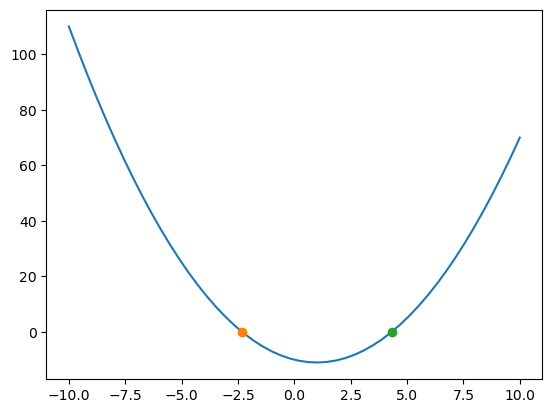

In [37]:
# Compute solution of f(x) = 0 by secant's Method 
_f = lambda x: x**2 - 2*x -10
_f_deriv = lambda x: 2*x + 2
_xs = np.linspace(-10,10)
x_sol0 = secant_method(-5,1,_f)
x_sol1 = secant_method(2,1,_f)
y_sol0, y_sol1 = 0,0

plt.plot(_xs, [_f(x) for x in _xs])
plt.plot(x_sol0, y_sol0, x_sol1, y_sol1, marker = 'o')

x_sol0, x_sol1

In [38]:
print (bisection(_f,{'a':-5,'b':1}, app=10**(-6)))
print (bisection(_f,{'a':1,'b':5}, app=10**(-6)))

-2.316624402999878
4.316624641418457


[Back to Index](#Index)

## Previous Exams

### Fall 2016

### 1. Implied Volatility

In [62]:
T = 3/12
S = 30
K = 30
q = 0.02
C = 2.5
r = 0.06
implied_vol_Newton(C, S, K, T, q, r, tol, 0.5)

0.5
0.39691563052053713
0.39704862856860385
0.39704862873147384


0.39704862873147356

In [61]:
C = 10
S = 50
K = 55
T = 8/12
q = 0.008
r = 0.02
tol = 10**(-10)
x0 = 0.25

implied_vol_Newton( C, S, K, T, q, r, tol, x0)

0.25
0.7487176315217889
0.7273082814081175
0.7273301503875844


0.7273301504094644

In [59]:
# EXAM
C = 15
S = 70
K = 75
T = 8/12
q = 0.007
r = 0.005
tol = 10**(-9)
x0 = 0.25

round(implied_vol_Newton( C, S, K, T, q, r, tol, x0),5)

0.25
0.7638523649833195
0.7525784017840881
0.7525853731785372


0.75259

In [43]:
print (round(0.763852289133,5))
print (round(0.752578579712,5))
print (round(0.752585540546,5))

0.76385
0.75258
0.75259


### 2. Boostrapping

TODO

In [44]:
edt =     pd.DataFrame( {'Maturity_in_months' : [12, 24, 48],
                        'Coupon_Rate' : [5, 0, 9],
                        'Price' : [104, 96, 115]},
                     columns = ['Maturity_in_months', 'Coupon_Rate', 'Price'])
edt

,Maturity_in_months,Coupon_Rate,Price
0,12,5,104
1,24,0,96
2,48,9,115


In [45]:
overnight = 0.002

### 3. i Cash flows and discount factors

In [435]:
def risk_zero_curve(t):
    return 0.02 +  (2 + 5*t**2)/(45+550*t**2)

def disc(t):
    return np.exp(- risk_zero_curve(t)*t)

In [436]:
#semianual
c = 0.08
t_cash_flow = [3/12, 9/12, 15/12, 21/12, 27/12]
v_cash_flow = get_value_cash_flows(5,c/2) #because semiannual
discs = [disc(t) for t in t_cash_flow]
n = len(t_cash_flow)

In [437]:
print (t_cash_flow)
print (v_cash_flow)
print (discs)

[0.25, 0.75, 1.25, 1.75, 2.25]
[4.0, 4.0, 4.0, 4.0, 104.0]
[0.9877916692348471, 0.9751293158040495, 0.9621715255786956, 0.9488363180275128, 0.9354573902171761]


### 3.ii Yield  

In [50]:
B

120

In [51]:
B = bond_price(t_cash_flow, v_cash_flow)  
y = bond_yield_Newton(B, n, t_cash_flow, v_cash_flow , tol = 10**(-5))
y

0.1
0.024153
0.029784
0.029819


0.029819399122059262

### 3.iii Modified duration, dollar duration, DV01, convexity and dollar convexity 

In [159]:
B,D, convexity = price_duration_convexity(n,t_cash_flow,v_cash_flow, y)

In [160]:
round(B,6),round(D,6),round(convexity,6)

(7.564815, 0.61797, 0.459978)

In [544]:
round(B*D,6) # dollar duration

234.202548

In [545]:
B*convexity #dollar convexity

512.43101063276379

In [546]:
B*D/10000

0.023420254767134382

### 3.iv Simpson's Rule for discount factors

# Miscelanea

In [55]:
# Define a matrix with x1, x2, x3 and 
A = np.array([[1, 0.3, -0.6],
              [0, 0.15, 0.3],
              [0, 0.12, 0.16]]) 

#define matrix B with the require hedging portfolio Delta, Gamma and Vega
B = np.array([-200, -60, -50]) 

# linalg.solve is the function of NumPy to solve a system of linear scalar equations
print ("Solutions:\n",np.linalg.solve(A, B ))

Solutions:
 [ -50. -450.   25.]


In [8]:
def bsm_vega(S0, K, T, r, q,  sigma):
    ''' Vega of European option in BSM model.
    
    Parameters
    ==========
    S0 : float
        initial stock/index level
    K : float
        strike price
    T : float
        maturity date (in year fractions)
    r : float
        constant risk-free short rate
    sigma : float
        volatility factor in diffusion term
    
    Returns
    =======
    vega : float
        partial derivative of BSM formula with respect
        to sigma, i.e. Vega
    '''
    from math import log, sqrt
    from scipy import stats

    S0 = float(S0)
    d1 = (log(S0 / K) + ((r - q) + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    vega = S0 * np.exp(-q*T) * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

In [460]:
def theta_calc(r, S, K, T, sigma):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    #try:
        #if type == "c":
    theta_calc = -S*norm.pdf(d1, 0, 1)*sigma/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        #elif type == "p":
            #theta_calc = -S*norm.pdf(d1, 0, 1)*sigma/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-d2, 0, 1)
    return theta_calc/365 #, theta(S, K, T, r, sigma)
    #except:
        #print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [461]:
theta_calc(r = 0.03, S = 50, K = 45, T = 9/12, sigma = 0.2)

-0.007176618308454315

In [462]:
S0 = 50  # Current price
T = 9/12  # Time to expiration
sigma = 0.2  # Volatility
q = 0.00  # Continuous dividends
r = 0.03  # Risk-free rate
K = 45


european_bsm_value(S0, K, T, r, sigma, q, option_type = 'call')

7.086333898580811

$ \Delta_c = \dfrac{V(S+dS)-V(S-dS) } {2dS}$

$\Gamma_c = \dfrac{V(S+dS)- 2V(S) + V(S-dS) } {(dS)^2}$

$\Theta_f = \dfrac{V(T-dt) - V(T)} {dt} $

In [57]:
def ThetaFinDiffApprxF(vt_m,vt,dt):
    return (vt_m-vt) / dt 

In [58]:
def relative_error(C_BS, C_approx):
    return np.abs(C_BS - C_approx) / C_BS


# Devoir 5

In [478]:
implied_vol_Newton( C=2.5, S=30, K=30, T=6/12, q=0.01, r=0.03, tol=10**(-6), x0=0.05)

(4, [0.05, 0.28803813, 0.28075506, 0.28075578], 0.2807557778368447)

In [473]:
S0 = 40  # Current price
T = 5/12  # Time to expiration
sigma = 0.1  # Volatility
q = 0.01  # Continuous dividends
r = 0.025  # Risk-free rate
K = 40


european_bsm_value(S0, K, T, r, sigma, q, option_type = 'call')

1.151287632557029

In [475]:
# Finding implied volatility using Bisection method

a = 0.0001;
b = 1;
tol = 10**(-6);

cMarket = 1.35;

while (b-a > tol):
    if european_bsm_value(S0, K, T, r, (a+b)/2, q, option_type = 'call') - cMarket > 0:
        b = (a+b)/2
    else :
        a = (a+b)/2

print("The implied volatiltiy at market price " + str(cMarket) + " is "  + str(a))

The implied volatiltiy at market price 1.35 is 0.11952050609588621


In [479]:
implied_vol_Newton( C=2.75, S=40, K=40, T=5/12, q=0.01, r=0.025, tol=10**(-6), x0=0.05)

(4, [0.05, 0.25978324, 0.25690308, 0.25690317], 0.2569031723648245)

In [494]:
def imp_vol_approx(C,S,K,T,r,q):
    
    vol_approx = (sqrt(2*np.pi)/S*sqrt(T))*((C-(((r-q)*T)*S)/2))/(1-(((r+q)*T)/2))
    
    #vol_newton = implied_vol_Newton( C, S, K, T, q, r, tol, x0)
    
    #relative_error = ((vol_approx-implied_vol_Newton( C, S, K, T, q, r, tol, x0))/implied_vol_Newton( C, S, K, T, q, r, tol, x0))
    
    relative_error = ((vol_approx-0.2569031723648245)/0.2569031723648245)
    
    return vol_approx, relative_error

In [495]:
imp_vol_approx(C=2.75,S=40,K=40,T=5/12,r=0.025,q=0.01)

(0.10696260273785332, -0.5836462362327031)

In [496]:
C = 0.04
#y = 0.09
t_cash_flow = [6/12, 12/12, 18/12, 24/12, 30/12, 36/12]
n = len(t_cash_flow)
v_cash_flow = get_value_cash_flows(n, C/2)

bond_price(t_cash_flow, v_cash_flow)

100.19895582438596

In [497]:
# Yield given price and cash flows 
yld = bond_yield_Newton(bond_price(t_cash_flow,v_cash_flow),
                  n, t_cash_flow, v_cash_flow , tol = 10**(-6))
yld

0.1
0.033082
0.03886
0.03891


0.0389095210938918

In [498]:
# Price, Duration and Convexity of bond given yield
_, mod_dur, convxty  = price_duration_convexity(n,t_cash_flow,v_cash_flow, yld)
print ('Yield: {}'.format(round(yld,6)))
print ('Modified Duration: {}'.format(round(mod_dur,6)))
print ('Convexity: {}'.format(round(convxty,6)))

Yield: 0.03891
Modified Duration: 2.8569
Convexity: 8.405898


In [538]:
C = 0.08
y = 0.09
t_cash_flow = [3/12, 6/12, 9/12, 12/12, 15/12, 18/12, 21/12, 24/12]
n = len(t_cash_flow)
v_cash_flow = get_value_cash_flows(n, C/4)

bond_price(t_cash_flow, v_cash_flow)

108.0465545677911

In [512]:
# Price, Duration and Convexity of bond given yield
_, mod_dur, convxty  = price_duration_convexity(n,t_cash_flow,v_cash_flow, y)
print ('Yield: {}'.format(round(y,6)))
print ('Modified Duration: {}'.format(round(mod_dur,6)))
print ('Convexity: {}'.format(round(convxty,6)))

Yield: 0.09
Modified Duration: 1.866374
Convexity: 3.634759


In [523]:
B = bond_price(t_cash_flow, v_cash_flow)
Bnew = B -D*0.04
Bnew

107.95457633777836

In [561]:
B = bond_price(t_cash_flow, v_cash_flow)
dy = 0.04
BnewC = (B -D*dy) + 0.5*3.634759*dy**2
BnewC

107.95748414497837

In [576]:
B = bond_price(t_cash_flow, v_cash_flow)
dy = 0.04
Bnew = B -D*dy
Bnew

107.95457633777836

In [577]:
dy = 0.04
dB = B + (B*(y+dy))
dB

122.09260666160395

In [578]:
(Bnew-dB)/dB

-0.11579759586107485

# SAMI EXAM

# Question 1

In [467]:

C = 8.50
S = 50
K = 45
T = 9/12
q = 0.005
r = 0.015
tol = 10**(-8)
x0 = 0.2

implied_vol_Newton( C, S, K, T, q, r, tol, x0)

(4, [0.2, 0.34671368, 0.33503799, 0.33501356], 0.3350135594689695)

In [469]:
def implied_vol_Newton(C, S, K, T, q, r, tol, x0):
    '''
    Inputs 
        C : price of the call option
        S : spot price of the underlying asset
        K : strike price of the option
        T : maturity of the option
        q : dividend yield of the underlying asset
        r : risk-free constant rate
        tol : tolerance for declaring convergence of Newton's method
        x0: initial guess
        f_BS : Black-Scholes value for a call given volatility
        vega_BS : vega of the call given volatility
    Output: implied volatility
    '''
    x_new = x0
    x_old = x0 - 1
    it = 0
    approx_values = []  # List to store approximate values
    while True:
        x_old_str = "{:.8f}".format(x_old)  # Format x_old to 8 decimal places
        x_new_str = "{:.8f}".format(x_new)  # Format x_new to 8 decimal places
        
        if x_old_str == x_new_str:
            break  # Stop iteration if 8 decimal places match
            
        x_old = x_new
        approx_values.append(round(x_new, 8))  # Store approximate value
        x_new = (x_new - (european_bsm_value(S, K, T, r, x_new, option_type='call', q=q) - C)
                 / bsm_vega(S, K, T, r, q, x_new))
        it += 1
    
    return it, approx_values, x_new

# Given parameters
S = 30
K = 30
T = 6/12
q = 0.001
r = 0.03
tol = 10**(-6)
x0 = 0.5

iterations, approximate_values, implied_vol = implied_vol_Newton(C, S, K, T, q, r, tol, x0)

# Report iteration count and every approximate value
print(f"Iteration count to convergence: {iterations}")
print("Approximate values at each iteration:")
for i, val in enumerate(approximate_values):
    print(f"Iteration {i + 1}: {val}")

# Report final implied volatility rounded to 8 decimal places
print(f"Implied Volatility: {implied_vol:.8f}")


Iteration count to convergence: 4
Approximate values at each iteration:
Iteration 1: 0.5
Iteration 2: 0.99678202
Iteration 3: 1.00716117
Iteration 4: 1.00716789
Implied Volatility: 1.00716789


# Question 2

In [465]:
# Boostrapping

# Inputs: Maturity, Coupon Rate and Price for a set of bonds with different maturities
# Steps: 
# 1) Solve for the interest rate for known rates
# 2) If there is a gap in maturities, make x as unknown and explain the rest as linear combinations of the unkonwn

dt =     pd.DataFrame( {'Maturity_in_months' : [12, 18, 36],
                        'Coupon_Rate' : [3, 2, 6],
                        'Price' : [101.25, 99.95, 110.30]},
                     columns = ['Maturity_in_months', 'Coupon_Rate', 'Price'])
dt

,Maturity_in_months,Coupon_Rate,Price
0,12,3,101.25
1,18,2,99.95
2,36,6,110.30


In [445]:
def risk_zero_curve(t):
    return 0.02 +  (1 + 2*t**2)/(100+100*t**2)

def disc(t):
    return np.exp(- risk_zero_curve(t)*t)

In [446]:
#semianual
c = 0.05
t_cash_flow = [5/12, 11/12, 17/12, 23/12, 29/12]
v_cash_flow = get_value_cash_flows(5,c/2) #because semiannual
discs = [disc(t) for t in t_cash_flow]
n = len(t_cash_flow)

In [447]:
print (t_cash_flow)
print (v_cash_flow)
print (discs)
print(bond_price(t_cash_flow, v_cash_flow))

[0.4166666666666667, 0.9166666666666666, 1.4166666666666667, 1.9166666666666667, 2.4166666666666665]
[2.5, 2.5, 2.5, 2.5, 102.5]
[0.9869692739246305, 0.9688111917895599, 0.9493712550673131, 0.930004711658882, 0.9110717076132214]
102.97274111145616


In [412]:
r_00 = 0.015
def get_implied_rate_r01(B, c, r_00, x0=0.05):
    '''
    XXX
    Semianual
    '''
    r_05 = lambda x: (r_00 + x)/2
    r_1 = lambda x: x
    
    x_new = x0
    x_old = x0 - 1
    it = 0
    while np.abs(x_new - x_old) > 10**(-6):
        x_old = x_new
        print (x_new)
        f = ( c/2*np.exp(-0.5 * r_05(x_new)) +
            (100 + c/2)*np.exp(-1 * r_1(x_new)) - B )
        
        f_p = ( -0.5 * c/2 * np.exp(-0.5 * r_05(x_new)) + 
                -1 * (100 + c/2) * np.exp(-1 * r_1(x_new)))
        x_new = (x_new - f/f_p)
    return x_new



In [414]:
B = dt.Price[0]
c = dt.Coupon_Rate[0]
t = dt.Maturity_in_months[0]/12
r_1 = get_implied_rate_r01(B,c,r_00) 


r_05 = lambda x: (r_00 + x)/2
r_1
r_05 = r_05(r_1)
round(r_05, 6), round(r_1,6)

0.05
0.016857151366011028
0.017269302864566474
0.017270912857378293


(0.016135, 0.017271)

In [416]:
import math

# Given zero rates
r_05
r_1

# Function definition
def f(x):
    return 1 * math.exp(-0.5 * r_05) + 1 * math.exp(-1 * r_1) + 101 * math.exp(-1.5 * x) - 99.95

# Derivative of the function
def f_prime(x):
    return -1.5 * 101 * math.exp(-1.5 * x)

# Initial guess for x
x_guess = 0.05  # You can choose any initial guess

# Newton's method
max_iterations = 10000
tolerance = 1e-6
x_old = x_guess

for i in range(max_iterations):
    f_val = f(x_old)
    f_prime_val = f_prime(x_old)
    
    x_new = x_old - f_val / f_prime_val
    
    if abs(x_new - x_old) < tolerance:
        break
    
    x_old = x_new

r_15 = x_old
print("The value of r_15 is:", r_15)


The value of r_15 is: 0.020270701315003227


In [299]:
import math

# Linear interpolation to find r_2 and r_2.5
r_1 = 0.017271
r_15 = 0.020271

r_2 = 0.018357
r_25 = 0.016442


# Newton's method to find r_3
def bond_price(r_3):
    x = 0.016135
    coupon = 2.5
    price = 110.30
    return coupon * math.exp(-0.5 * r_05) + coupon * math.exp(-1 * r_1) + coupon * math.exp(-1.5 * r_15) + coupon * math.exp(-2 * r_2) + coupon * math.exp(-2.5 * r_25) + 102.5 * math.exp(-3 * r_3) - price

def bond_price_derivative(r_3):
    return -102.5 * 3 * math.exp(-3 * r_3)

# Initial guess for r_3
r_3 = 0.05
iterations = 0
max_iterations = 100
tolerance = 1e-6

while True:
    f_r_3 = bond_price(r_3)
    f_prime_r_3 = bond_price_derivative(r_3)
    
    r_3_new = r_3 - f_r_3 / f_prime_r_3
    
    if abs(r_3_new - r_3) < tolerance:
        break
    
    r_3 = r_3_new
    iterations += 1
    
    if iterations >= max_iterations:
        print("Did not converge within the maximum number of iterations.")
        break

print(f"Calculated r_2: {r_2}")
print(f"Calculated r_2.5: {r_25}")
print(f"Calculated r_3: {r_3}")


Calculated r_2: 0.018357
Calculated r_2.5: 0.016442
Calculated r_3: 0.014528093103768005


In [402]:
0.5*r_3+0.5*r_1

0.015899546551884004

In [417]:
def get_implied_rate_r03( B, c, r_05, r_1, r_15, x0 = 0.05):
    '''
    XXX
    Semianual
    '''

    r_2 =  lambda x: 0.5*x + 0.5*r_1
    r_25 = lambda x: (0.5/2)*x + (1.5/2)*r_1
    r_3 = lambda x: x
    
    x_new = x0
    x_old = x0 - 1
    it = 0
    while np.abs(x_new - x_old) > 10**(-6):
        x_old = x_new
        print ('Iter/Imp rate r03: {}/{}'.format(it,x_new))
        it += 1
        f = ( c/2*np.exp(-0.5 * r_05) +
              c/2*np.exp(-1 * r_1) +
              c/2*np.exp(-1.5 * r_15) +
              c/2*np.exp(-2 * r_2(x_new)) +
              c/2*np.exp(-2.5 * r_25(x_new)) +
              (100 + c/2)*np.exp(-3 * r_3(x_new)) - B )
        
        f_p = ( -2 * c/2 * np.exp(-2 * r_2(x_new)) + 
                -2.5 * c/2 * np.exp(-2.5 * r_25(x_new)) +
                -3 * (100 + c/2) * np.exp(-3 * r_3(x_new)) )
        
        x_new = (x_new - f/f_p)
    return x_new

In [418]:
## t = 3ans
B = dt.Price[2]
c = dt.Coupon_Rate[2]
t = dt.Maturity_in_months[2]/12
r_3 = get_implied_rate_r03(B,c,r_05,r_1,r_15,x0 = 0.05)

# intermediate ts

#r_2 = lambda x: 1/2*x + 1/2 * r_1
#r_25 = lambda x: 1.5/2*x + 0.5/2 * r_1

r_2 =  lambda x: 0.5*x + 0.5*r_1
r_25 = lambda x: (0.5/2)*x + (1.5/2)*r_1

r_2 = r_2(r_3)
r_25 = r_25(r_3)

r_2, r_25, r_3

Iter/Imp rate r03: 0/0.05
Iter/Imp rate r03: 1/0.02418389088365747
Iter/Imp rate r03: 2/0.024402079117713076
Iter/Imp rate r03: 3/0.02440814047059444


(0.020839612897574543, 0.019055265857524976, 0.024408306977673676)

# Question 3 

In [444]:
C = 0.05
#y = 0.09
t_cash_flow = [5/12, 11/12, 17/12, 23/12, 29/12]
n = len(t_cash_flow)
v_cash_flow = get_value_cash_flows(n, C/2)

# Bond price given zero rate curve
def risk_zero_curve(t):
    return 0.02 + (1+2*t**2)/(100+100*t**2)

bond_price(t_cash_flow, v_cash_flow)

102.97274111145616

In [429]:
import numpy as np

def get_value_cash_flows(n, C, FV=100):
    cash_flows = [C * FV] * n
    cash_flows[-1] += FV  # Add principal at final cash flow
    return cash_flows

# Given cash flow dates for 28-month maturity
cash_flow_dates = [5/12, 11/12, 17/12, 23/12, 29/12]

# Bond price given zero rate curve
def risk_zero_curve(t):
    return 0.02 + (1+2*t**2)/(100+100*t**2)

def calculate_discount_factors(cash_flow_dates):
    return [np.exp(-risk_zero_curve(t)*t) for t in cash_flow_dates]

def list_cash_flows_and_discount_factors():
    cash_flows = get_value_cash_flows(len(cash_flow_dates), C/2, FV=100)
    discount_factors = calculate_discount_factors(cash_flow_dates)
    
    for i in range(len(cash_flow_dates)):
        print(f"Cash Flow Date: {cash_flow_dates[i]:.2f} - Cash Flow Value: ${cash_flows[i]:.2f} - Discount Factor: {discount_factors[i]:.6f}")

    # Final Cash Flow (at maturity)
    print(f"Final Cash Flow Date: {cash_flow_dates[-1]:.2f} - Final Cash Flow Value: ${cash_flows[-1]:.2f} - Discount Factor: {discount_factors[-1]:.6f}")

# Outputting the cash flows, their dates, and discount factors
list_cash_flows_and_discount_factors()



Cash Flow Date: 0.42 - Cash Flow Value: $2.50 - Discount Factor: 0.986969
Cash Flow Date: 0.92 - Cash Flow Value: $2.50 - Discount Factor: 0.968811
Cash Flow Date: 1.42 - Cash Flow Value: $2.50 - Discount Factor: 0.949371
Cash Flow Date: 1.92 - Cash Flow Value: $2.50 - Discount Factor: 0.930005
Cash Flow Date: 2.42 - Cash Flow Value: $102.50 - Discount Factor: 0.911072
Final Cash Flow Date: 2.42 - Final Cash Flow Value: $102.50 - Discount Factor: 0.911072


In [431]:
def disc(t):
    return np.exp(- risk_zero_curve(t)*t)

discs = [disc(t) for t in t_cash_flow]
print (discs)

[0.9869692739246305, 0.9688111917895599, 0.9493712550673131, 0.930004711658882, 0.9110717076132214]


In [448]:
# Yield given price and cash flows 
yld = bond_yield_Newton(bond_price(t_cash_flow,v_cash_flow),
                  n, t_cash_flow, v_cash_flow , tol = 10**(-6))
yld

0.1
0.033716
0.038405
0.038431


0.03843110015651552

In [449]:
B = bond_price(t_cash_flow, v_cash_flow)  
y = bond_yield_Newton(B, n, t_cash_flow, v_cash_flow , tol = 10**(-6))
y
B

0.1
0.033716
0.038405
0.038431


102.97274111145616

In [450]:
# Price, Duration and Convexity of bond given yield
_, mod_dur, convxty  = price_duration_convexity(n,t_cash_flow,v_cash_flow, yld)
print ('Yield: {}'.format(round(yld,6)))
print ('Modified Duration: {}'.format(round(mod_dur,6)))
print ('Convexity: {}'.format(round(convxty,6)))

Yield: 0.038431
Modified Duration: 2.299456
Convexity: 5.450694


In [451]:
B, D, convexity = price_duration_convexity(n,t_cash_flow,v_cash_flow,y)
print ('Bond Price: {}'.format(round(B,6)))
print ('Bond Duration: {}'.format(round(D,6)))
print ('Bond Convexity: {}'.format(round(convexity,6)))

Bond Price: 102.972741
Bond Duration: 2.299456
Bond Convexity: 5.450694


In [452]:
round(B,6),round(D,6),round(convexity,6)

(102.972741, 2.299456, 5.450694)

In [453]:
round(B*D,6) # dollar duration

236.781262

In [456]:
round(B*convexity,6) #dollar convexity

561.272934

In [455]:
B*D/10000

0.023678126167481096

# Question 4

# Function to calculate Black-Scholes put option value
def european_bsm_value( S0, K, T, r, sigma, option_type = 'call',q = 0 ):
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    
    Parameters
    ==========
    option_type :  string
        call/put
    S0 : float
        initial stock/index level
    K : float
        strike price
    T : float
        maturity date (in year fractions)
    r : float
        constant risk-free short rate
    sigma : float
        volatility factor in diffusion term
    
    Returns
    =======
    value : float
        present value of the European call option
    '''
    from math import log, sqrt, exp
    from scipy import stats
    
    if option_type not in ['call','put']:
        print  ('Invalid option_type, input should be "call" or "put"}')
        return None
    
    S0 = float(S0)
    d1 = (log(S0) - log(K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    return d1
    d2 = d1 - sigma * sqrt(T)
    return d2
    C = (S0 * exp(-q * T) * norm.cdf(d1)
         - K * exp(-r * T) * norm.cdf(d2))
    P = (K * exp(-r * T) * norm.cdf(-d2)  
         - S0 * exp(-q * T) * norm.cdf(-d1))
    if option_type == 'call':
        return C,d1,d2
    if option_type == 'put':
        return P,d1,d2

In [457]:
S0 = 50  # Current price
T = 0.5  # Time to expiration
sigma = 0.3  # Volatility
q = 0.01  # Continuous dividends
r = 0.03  # Risk-free rate
K = 50


european_bsm_value(S0, K, T, r, sigma, q, option_type = 'put')

3.9386434108756134

In [458]:
import math

# Derivative of Black-Scholes put option w.r.t. strike price
def derivative_BS_put(S0, K, T, q, r, sigma):
    d1 = (np.log(S0) - np.log(K) + (r - q + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    derivative = (np.exp((-r * T)) * (norm.cdf(-d2)))-1
    return derivative

# Newton's method to find implied strike
def find_implied_strike(S0, T, q, r, sigma, tolerance, x0):
    # Initial guess for strike price
    x_new = x0
    x_old = x0 - 1  # Initial guess slightly lower than S

    count = 0
    
    while np.abs(x_new - x_old) > tolerance:
        x_old = x_new
        print (x_new)
        count += 1
        f  = european_bsm_value(S0, x_new, T, r, sigma, q, option_type = 'put') - (x_new - S0)
        #f  = european_bsm_value(S0, x_new, T, r, sigma, q, option_type = 'put') - (S0)
        f_p = derivative_BS_put(S0, x_new, T, q, r, sigma)
        x_new = x_new - f / f_p
    
    return x_new, count

In [459]:
find_implied_strike(S0 = 50, T = 0.5, q = 0.01, r=0.03, sigma=0.3, tolerance=10**(-6), x0=50)

50
58.13266028399134
62.862109577421606
64.518772412038
64.68972829980311
64.69136851278859


(64.69136866194297, 6)

In [372]:
from math import log, sqrt, exp
from scipy.stats import norm

def find_strike_price(S, T, sigma, q, r, initial_guess):
    K = initial_guess
    epsilon = 1e-6  # convergence criterion
    max_iterations = 1000

    for iteration in range(max_iterations):
        P_BS = european_bsm_value(S, K, T, r, sigma, q, option_type = 'put')
        diff = P_BS - (K - S)

        # Derivative of Black-Scholes put price with respect to K (simplified)
        d2 = (log(S / K) + (r - q - 0.5 * sigma**2) * T) / (sigma * sqrt(T))
        derivative = (exp(-r * T) * norm.cdf(-d2))-1

        # Newton's method update
        K_next = K - diff / derivative

        # Output the current iteration and value
        print(f"Iteration {iteration + 1}: {K:.6f}")

        # Check convergence criterion (6 decimal places)
        if abs(K - K_next) < epsilon:
            print(f"Convergence reached after {iteration + 1} iterations.")
            break

        K = K_next  # Update K for the next iteration



In [397]:
find_strike_price(S=50, T=0.5, sigma=0.25, q=0.01, r=0.03, initial_guess=50)

Iteration 1: 50.000000
Iteration 2: 56.555634
Iteration 3: 60.128386
Iteration 4: 61.244916
Iteration 5: 61.338464
Iteration 6: 61.339068
Convergence reached after 6 iterations.
